In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')
import IPython.display as ipd
from scipy.io import wavfile
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Masking
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import librosa.display
from tensorflow.keras.models import load_model
# from keras.utils import np_utils
from sklearn import metrics 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
matplotlib.style.use('ggplot')
import IPython.display as ipd
from scipy.io import wavfile
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier


from tqdm import tqdm

In [2]:
# Generate full file paths for each file
newGunShotLocs = [r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MIVIA_DB4_dist\training\train_new_gunshots/' + file for file in os.listdir(r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MIVIA_DB4_dist\training\train_new_gunshots')] + \
                 [r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MIVIA_DB4_dist\testing\test_new_gunshots/' + file for file in os.listdir(r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MIVIA_DB4_dist\testing\test_new_gunshots')]

# Create the DataFrame with file names (paths) and labels
newGunShot = pd.DataFrame(data = dict(fname = newGunShotLocs, label = ['Gunshot_or_gunfire'] * len(newGunShotLocs)))


In [3]:
# Generate full file paths for each file
newShatterLocs = [r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MIVIA_DB4_dist\training\train_new_glass/' + file for file in os.listdir(r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MIVIA_DB4_dist\training\train_new_glass')] + \
                 [r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MIVIA_DB4_dist\testing\test_new_glass/' + file for file in os.listdir(r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MIVIA_DB4_dist\testing\test_new_glass')]

# Create the DataFrame with file names (paths) and labels
newShatter = pd.DataFrame(data = dict(fname = newShatterLocs, label = ['Shatter'] * len(newShatterLocs)))


In [4]:
# Generate full file paths for each file
newScreamsLocs = [r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MIVIA_DB4_dist\training\train_new_Screams/' + file for file in os.listdir(r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MIVIA_DB4_dist\training\train_new_Screams')] + \
                 [r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MIVIA_DB4_dist\testing\test_new_Screams/' + file for file in os.listdir(r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MIVIA_DB4_dist\testing\test_new_Screams')]

# Create the DataFrame with file names (paths) and labels
newScreams = pd.DataFrame(data = dict(fname = newScreamsLocs, label = ['Screams'] * len(newScreamsLocs)))


In [5]:
# Augmentation methods
#########################
def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*1000)  #default at 500
    return np.roll(data, s_range)
    
def stretch(data):
    """
    Streching the Sound. Note that this expands the dataset slightly
    """
    data = librosa.effects.time_stretch(data, rate=0.8)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=-0.5 ,high=7)  # default low = 1.5, high = 3
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

import scipy.signal

def reverb(X, reverb_factor=0.5):
    impulse_response = np.random.normal(size=500)  # Example impulse response
    return scipy.signal.convolve(X, impulse_response, mode='same') * reverb_factor


####################################
# the confusion matrix heat map plot
####################################
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [3]:
import soundfile as sf

In [7]:
# Generate full file paths for each file
newBgLocs = [r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MS-SNSD\noise_train/' + file for file in os.listdir(r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MS-SNSD\noise_train')] + \
                 [r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MS-SNSD\noise_test/' + file for file in os.listdir(r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MS-SNSD\noise_test')]

# Create the DataFrame with file names (paths) and labels
newBg = pd.DataFrame(data = dict(fname = newBgLocs, label = ['background_noise'] * len(newBgLocs)))


In [20]:
output_dir = 'augmented_data_bg'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

processed_paths  = []
cnt = 0

for i, (fname, label) in tqdm(enumerate(zip(newBg['fname'], newBg['label'])), total=len(newBg)):
    # Load the audio file
    audio, sample_rate = librosa.load(fname, res_type='kaiser_fast', sr=32000, mono=True)
    
    # Clear augmented_audios list for each file
    augmented_audios = []

    # Apply augmentations
    augmented_audios.append(shift(audio))
    augmented_audios.append(speedNpitch(audio))

    # Save each augmented audio
    for j, aug_audio in enumerate(augmented_audios):
        output_path = f'{output_dir}/augmented_audio_{i}_{j}.wav'
        sf.write(output_path, aug_audio, sample_rate)
        processed_paths.append(output_path)
        cnt += 1


100%|██████████| 178/178 [03:06<00:00,  1.05s/it]


In [17]:
newBg

,fname,label
0,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
1,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
2,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
3,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
4,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
...,...,...
173,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
174,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
175,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
176,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise


In [8]:
# Generate full file paths for each file
newcleanLocs = [r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MS-SNSD\clean_train/' + file for file in os.listdir(r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MS-SNSD\clean_train')] + \
                 [r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MS-SNSD\clean_test/' + file for file in os.listdir(r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MS-SNSD\clean_test')]

# Create the DataFrame with file names (paths) and labels
newclean = pd.DataFrame(data = dict(fname = newcleanLocs, label = ['background_noise'] * len(newcleanLocs)))


In [40]:
newclean_df = newclean.sample(7466)

In [13]:
happy_data_path =r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MIVIA_DB4_dist\training\train_new_background\background_trimmed_data\background_noise'
emotions = []
path =[]
def load_happy_data(emotions, path):
    for dirname, _, filenames in os.walk(happy_data_path):
        # print(filename)
        for filename in filenames:
            name = os.path.join( filename)
            emotions.append('background_noise')
            path.append(f'{happy_data_path}\\{ name}')



    happy_df = pd.DataFrame(emotions, columns = ['label'])
  
    happy_df['fname'] = pd.concat([pd.Series(path)], ignore_index=True)
    # SAVEE_df['Paths'][0]

    return happy_df


In [21]:
happy_data_path =r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MIVIA_DB4_dist\training\train_new_background\gun_shot_augmented_data'
emotions = []
path =[]
def load_happy_data(emotions, path):
    for dirname, _, filenames in os.walk(happy_data_path):
        # print(filename)
        for filename in filenames:
            name = os.path.join( filename)
            emotions.append('Gunshot_or_gunfire')
            path.append(f'{happy_data_path}\\{ name}')



    happy_df = pd.DataFrame(emotions, columns = ['label'])
  
    happy_df['fname'] = pd.concat([pd.Series(path)], ignore_index=True)
    # SAVEE_df['Paths'][0]

    return happy_df


In [22]:
gunaugdf = load_happy_data(emotions, path)

In [23]:
gunaugdf

,label,fname
0,Gunshot_or_gunfire,C:\Users\JoVa994\Documents\Vandalism_Detection...
1,Gunshot_or_gunfire,C:\Users\JoVa994\Documents\Vandalism_Detection...
2,Gunshot_or_gunfire,C:\Users\JoVa994\Documents\Vandalism_Detection...
3,Gunshot_or_gunfire,C:\Users\JoVa994\Documents\Vandalism_Detection...
4,Gunshot_or_gunfire,C:\Users\JoVa994\Documents\Vandalism_Detection...
...,...,...
1697,Gunshot_or_gunfire,C:\Users\JoVa994\Documents\Vandalism_Detection...
1698,Gunshot_or_gunfire,C:\Users\JoVa994\Documents\Vandalism_Detection...
1699,Gunshot_or_gunfire,C:\Users\JoVa994\Documents\Vandalism_Detection...
1700,Gunshot_or_gunfire,C:\Users\JoVa994\Documents\Vandalism_Detection...


In [14]:
Bg = load_happy_data(emotions, path)
Bg

,label,fname
0,background_noise,C:\Users\JoVa994\Documents\Vandalism_Detection...
1,background_noise,C:\Users\JoVa994\Documents\Vandalism_Detection...
2,background_noise,C:\Users\JoVa994\Documents\Vandalism_Detection...
3,background_noise,C:\Users\JoVa994\Documents\Vandalism_Detection...
4,background_noise,C:\Users\JoVa994\Documents\Vandalism_Detection...
...,...,...
7951,background_noise,C:\Users\JoVa994\Documents\Vandalism_Detection...
7952,background_noise,C:\Users\JoVa994\Documents\Vandalism_Detection...
7953,background_noise,C:\Users\JoVa994\Documents\Vandalism_Detection...
7954,background_noise,C:\Users\JoVa994\Documents\Vandalism_Detection...


In [41]:
augBg

,fname,label
0,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
1,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
2,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
3,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
4,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
...,...,...
351,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
352,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
353,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
354,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise


In [16]:
col = ['fname', 'label']
Bg = Bg[col]

In [42]:
bg_df = pd.concat([newBg, newclean_df, augBg], ignore_index=True)

In [43]:
bg_df

,fname,label
0,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
1,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
2,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
3,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
4,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
...,...,...
7995,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
7996,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
7997,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise
7998,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise


In [41]:
newGunShot = newGunShot.reset_index(drop=True)
newShatter = newShatter.reset_index(drop=True)
newScreams = newScreams.reset_index(drop=True)
# newBg= newBg.reset_index(drop=True)

In [19]:
gun_df = pd.read_csv('audio_files.csv')

In [30]:
gun_df['label'] = 'Gunshot_or_gunfire'

In [41]:
gun_df.rename(columns = {'path':'fname'}, inplace = True)


In [42]:
gun_df

,fname,label
0,C:\Users\JoVa994\Downloads\archive (5)\AK-12\3...,Gunshot_or_gunfire
1,C:\Users\JoVa994\Downloads\archive (5)\AK-12\3...,Gunshot_or_gunfire
2,C:\Users\JoVa994\Downloads\archive (5)\AK-12\3...,Gunshot_or_gunfire
3,C:\Users\JoVa994\Downloads\archive (5)\AK-12\3...,Gunshot_or_gunfire
4,C:\Users\JoVa994\Downloads\archive (5)\AK-12\3...,Gunshot_or_gunfire
...,...,...
846,C:\Users\JoVa994\Downloads\archive (5)\Zastava...,Gunshot_or_gunfire
847,C:\Users\JoVa994\Downloads\archive (5)\Zastava...,Gunshot_or_gunfire
848,C:\Users\JoVa994\Downloads\archive (5)\Zastava...,Gunshot_or_gunfire
849,C:\Users\JoVa994\Downloads\archive (5)\Zastava...,Gunshot_or_gunfire


In [26]:
8000-2553

5447

In [27]:
newGunShot = newGunShot.sample(5447)

In [43]:
df = pd.concat([newGunShot,newShatter,newScreams,Bg, gunaugdf, gun_df],axis = 0).reset_index(drop=True)


In [44]:
df

,fname,label
0,C:\Users\JoVa994\Documents\Vandalism_Detection...,Gunshot_or_gunfire
1,C:\Users\JoVa994\Documents\Vandalism_Detection...,Gunshot_or_gunfire
2,C:\Users\JoVa994\Documents\Vandalism_Detection...,Gunshot_or_gunfire
3,C:\Users\JoVa994\Documents\Vandalism_Detection...,Gunshot_or_gunfire
4,C:\Users\JoVa994\Documents\Vandalism_Detection...,Gunshot_or_gunfire
...,...,...
31951,C:\Users\JoVa994\Downloads\archive (5)\Zastava...,Gunshot_or_gunfire
31952,C:\Users\JoVa994\Downloads\archive (5)\Zastava...,Gunshot_or_gunfire
31953,C:\Users\JoVa994\Downloads\archive (5)\Zastava...,Gunshot_or_gunfire
31954,C:\Users\JoVa994\Downloads\archive (5)\Zastava...,Gunshot_or_gunfire


In [45]:
duration = []
for ind, row in tqdm(df.iterrows(), total=len(df)):
    duration.append(librosa.get_duration(filename=row['fname']))
df['duration'] = duration 

  0%|          | 0/31956 [00:00<?, ?it/s]C:\Users\JoVa994\AppData\Local\Temp\ipykernel_54456\195520949.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration.append(librosa.get_duration(filename=row['fname']))
100%|██████████| 31956/31956 [14:20<00:00, 37.13it/s]


In [33]:
df.label.value_counts()

Gunshot_or_gunfire    8000
Shatter               8000
Screams               8000
background_noise      7956
Name: label, dtype: int64

In [37]:
bg_df[bg_df['duration'] > 5]['fname'][0]

'C:\\Users\\JoVa994\\Documents\\Vandalism_Detection\\Data\\MS-SNSD\\noise_train/AirConditioner_1.wav'

In [46]:
df.duration.describe() 

count    31956.000000
mean         2.448060
std          5.575904
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max        360.000000
Name: duration, dtype: float64

In [50]:
df[df['duration'] >7]

,fname,label,duration
30357,C:\Users\JoVa994\Documents\Vandalism_Detection...,Gunshot_or_gunfire,360.0
30358,C:\Users\JoVa994\Documents\Vandalism_Detection...,Gunshot_or_gunfire,360.0
30733,C:\Users\JoVa994\Documents\Vandalism_Detection...,Gunshot_or_gunfire,320.0
30734,C:\Users\JoVa994\Documents\Vandalism_Detection...,Gunshot_or_gunfire,320.0
31075,C:\Users\JoVa994\Documents\Vandalism_Detection...,Gunshot_or_gunfire,305.0
31076,C:\Users\JoVa994\Documents\Vandalism_Detection...,Gunshot_or_gunfire,305.0
31157,C:\Users\JoVa994\Downloads\archive (5)\AK-12\3...,Gunshot_or_gunfire,360.0
31174,C:\Users\JoVa994\Downloads\archive (5)\AK-12\3...,Gunshot_or_gunfire,320.0
31192,C:\Users\JoVa994\Downloads\archive (5)\AK-12\3...,Gunshot_or_gunfire,305.0


In [53]:
df[df['duration'] >7]['fname'][30357]

'C:\\Users\\JoVa994\\Documents\\Vandalism_Detection\\Data\\MIVIA_DB4_dist\\training\\train_new_background\\gun_shot_augmented_data\\augmented_audio_52_0.wav'

In [54]:
df[df['duration'] == max(df['duration'])]

,fname,label,duration
8045,C:\Users\JoVa994\Documents\Vandalism_Detection...,Shatter,7.0
8046,C:\Users\JoVa994\Documents\Vandalism_Detection...,Shatter,7.0
8047,C:\Users\JoVa994\Documents\Vandalism_Detection...,Shatter,7.0
8048,C:\Users\JoVa994\Documents\Vandalism_Detection...,Shatter,7.0
8049,C:\Users\JoVa994\Documents\Vandalism_Detection...,Shatter,7.0
...,...,...,...
21327,C:\Users\JoVa994\Documents\Vandalism_Detection...,Screams,7.0
21328,C:\Users\JoVa994\Documents\Vandalism_Detection...,Screams,7.0
21329,C:\Users\JoVa994\Documents\Vandalism_Detection...,Screams,7.0
21330,C:\Users\JoVa994\Documents\Vandalism_Detection...,Screams,7.0


In [111]:
df.drop(df[df['duration'] >5].index, inplace = True)

In [54]:
df = df[df['duration'] <= 7]

In [55]:
df.duration.describe()

count    31947.000000
mean         2.356252
std          1.009770
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: duration, dtype: float64

In [45]:
import librosa
import soundfile as sf
import os
import pandas as pd

def trim_audio_to_5_seconds(input_path, output_path, duration=5):
    """
    Trim the audio file to 5 seconds and save the output.

    Args:
    - input_path (str): Path to the input audio file.
    - output_path (str): Path where the trimmed audio will be saved.
    - duration (int): Duration to trim the audio (default is 5 seconds).
    """
    try:
        # Load audio file
        y, sr = librosa.load(input_path)

        # Calculate the number of samples for the specified duration
        max_samples = duration * sr

        # Trim the audio to the first 'duration' seconds (or max_samples)
        y_trimmed = y[:max_samples]

        # Save the trimmed audio
        sf.write(output_path, y_trimmed, sr)
        print(f"Saved trimmed audio to {output_path}")
    
    except Exception as e:
        print(f"Error processing {input_path}: {e}")

def process_audio_from_df(df, path_column, label_column, output_base_dir, duration=5):
    """
    Process audio files from DataFrame paths: trim them to 5 seconds and save.

    Args:
    - df (pd.DataFrame): DataFrame containing file paths and labels.
    - path_column (str): Column name in the DataFrame that contains the file paths.
    - label_column (str): Column name in the DataFrame that contains the labels.
    - output_base_dir (str): Base directory where the trimmed audio files will be saved.
    - duration (int): Duration to trim the audio (default is 5 seconds).
    """
    # Create base output directory if it doesn't exist
    if not os.path.exists(output_base_dir):
        os.makedirs(output_base_dir)

    # Iterate over paths and labels in the DataFrame
    for idx, row in df.iterrows():
        input_path = row[path_column]
        label = row[label_column]
        
        # Create a folder for the current label if it doesn't exist
        label_dir = os.path.join(output_base_dir, str(label))
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)

        # Extract the file name from the path and create a new output path
        file_name = os.path.basename(input_path)
        output_path = os.path.join(label_dir, f"trimmed_{file_name}")

        # Trim and save the audio
        trim_audio_to_5_seconds(input_path, output_path, duration)


# Example usage
# Assuming big_df is the DataFrame with a column 'fname' for file paths and 'label' for labels
output_directory = 'background_trimmed_data'  # Base output directory

# Call the function
process_audio_from_df(bg_df, path_column='fname', label_column='label', output_base_dir=output_directory)


Saved trimmed audio to background_trimmed_data\background_noise\trimmed_AirConditioner_1.wav
Saved trimmed audio to background_trimmed_data\background_noise\trimmed_AirConditioner_10.wav
Saved trimmed audio to background_trimmed_data\background_noise\trimmed_AirConditioner_2.wav
Saved trimmed audio to background_trimmed_data\background_noise\trimmed_AirConditioner_3.wav
Saved trimmed audio to background_trimmed_data\background_noise\trimmed_AirConditioner_4.wav
Saved trimmed audio to background_trimmed_data\background_noise\trimmed_AirConditioner_5.wav
Saved trimmed audio to background_trimmed_data\background_noise\trimmed_AirConditioner_6.wav
Saved trimmed audio to background_trimmed_data\background_noise\trimmed_AirConditioner_7.wav
Saved trimmed audio to background_trimmed_data\background_noise\trimmed_AirConditioner_8.wav
Saved trimmed audio to background_trimmed_data\background_noise\trimmed_AirConditioner_9.wav
Saved trimmed audio to background_trimmed_data\background_noise\trimm

C:\Users\JoVa994\AppData\Local\Temp\ipykernel_40280\1372709448.py:17: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(input_path)
c:\Users\JoVa994\AppData\Local\anaconda3\envs\new_env\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Saved trimmed audio to background_trimmed_data\background_noise\trimmed_p310_323.wav
Saved trimmed audio to background_trimmed_data\background_noise\trimmed_p263_361.wav
Saved trimmed audio to background_trimmed_data\background_noise\trimmed_p312_152.wav
Saved trimmed audio to background_trimmed_data\background_noise\trimmed_p305_216.wav
Saved trimmed audio to background_trimmed_data\background_noise\trimmed_p333_147.wav
Saved trimmed audio to background_trimmed_data\background_noise\trimmed_p313_248.wav
Saved trimmed audio to background_trimmed_data\background_noise\trimmed_p343_365.wav
Saved trimmed audio to background_trimmed_data\background_noise\trimmed_p305_280.wav
Saved trimmed audio to background_trimmed_data\background_noise\trimmed_p347_099.wav
Saved trimmed audio to background_trimmed_data\background_noise\trimmed_p376_049.wav
Saved trimmed audio to background_trimmed_data\background_noise\trimmed_p361_174.wav
Saved trimmed audio to background_trimmed_data\background_noise\t

In [56]:
ipd.Audio(df['fname'][8049])

In [131]:
duration = []
for ind, row in tqdm(df.iterrows()):
    duration.append(librosa.get_duration(filename=row['fname']))
df['duration'] = duration 

32000it [05:47, 92.19it/s]  


Extracting Features

In [21]:
df

,fname,label,duration
0,./Data/MIVIA_DB4_dist/training/train_new_gunsh...,Gunshot_or_gunfire,1.0
1,./Data/MIVIA_DB4_dist/training/train_new_gunsh...,Gunshot_or_gunfire,2.0
2,./Data/MIVIA_DB4_dist/training/train_new_gunsh...,Gunshot_or_gunfire,2.0
3,./Data/MIVIA_DB4_dist/training/train_new_gunsh...,Gunshot_or_gunfire,2.0
4,./Data/MIVIA_DB4_dist/training/train_new_gunsh...,Gunshot_or_gunfire,2.0
...,...,...,...
23995,./Data/MIVIA_DB4_dist/testing/test_new_screams...,Shatter,2.0
23996,./Data/MIVIA_DB4_dist/testing/test_new_screams...,Shatter,2.0
23997,./Data/MIVIA_DB4_dist/testing/test_new_screams...,Shatter,2.0
23998,./Data/MIVIA_DB4_dist/testing/test_new_screams...,Shatter,2.0


In [22]:
# Load the audio file
# audio_data, sr = librosa.load(df['fname'][0], sr=44100)  

ipd.Audio(df['fname'][0])

In [45]:
df['duration'].describe()

count    31999.000000
mean         2.793431
std          1.496945
min          1.000000
25%          2.000000
50%          2.000000
75%          5.000000
max          7.000000
Name: duration, dtype: float64

In [62]:
import os
import librosa
import soundfile as sf

audio_resampled = []
def convert_sample_rate(input_file):
    audio_data, original_sr = librosa.load(input_file, sr=None) 
    audio_resampled.append(original_sr)
    # audio_resampled = librosa.resample(audio_data, orig_sr=original_sr, target_sr=target_sr)
    # sf.write(output_file, audio_resampled, target_sr)
    # print(f"Converted '{input_file}' from {original_sr} Hz to {target_sr} Hz and saved as '{output_file}'.")
    return audio_resampled
target_sample_rate = 44100 
# df['resampled2'] = audio_resampled


output_dir = r'C:\Users\JoVa994\Documents\Vandalism_Detection\Data\MIVIA_DB4_dist\resampled2'
os.makedirs(output_dir, exist_ok=True)

for index, row in df.iterrows():
    input_wav = row['fname']
    # output_wav = os.path.join(output_dir, os.path.basename(input_wav)) 
    resampled = convert_sample_rate(input_wav)

df['resampled2'] = resampled
    
  
    # test_new.at[index, 'resampled2'] = output_wav

In [64]:
df.resampled2.value_counts()

32000    24000
Name: resampled2, dtype: int64

In [132]:
df

,fname,label,duration
0,C:\Users\JoVa994\Documents\Vandalism_Detection...,Gunshot_or_gunfire,1.0
1,C:\Users\JoVa994\Documents\Vandalism_Detection...,Gunshot_or_gunfire,2.0
2,C:\Users\JoVa994\Documents\Vandalism_Detection...,Gunshot_or_gunfire,2.0
3,C:\Users\JoVa994\Documents\Vandalism_Detection...,Gunshot_or_gunfire,2.0
4,C:\Users\JoVa994\Documents\Vandalism_Detection...,Gunshot_or_gunfire,2.0
...,...,...,...
31995,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise,2.0
31996,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise,2.0
31997,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise,2.0
31998,C:\Users\JoVa994\Documents\Vandalism_Detection...,background_noise,2.0


Extracting Features

In [61]:
# frame_size 
window_size = 3.0 #seconds - 30MS
hop_length_factor = 0.5 # (50%)
# duration = 3.6
offset = None
sample_rate = 32000
n_mfcc = 13
n_mels = 128 

In [56]:
import numpy as np
import librosa
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm

def extract_features_with_windowing(audio, sample_rate, window_size_samples, hop_length_samples):
    """Extract features using sliding window with overlap."""
    features_dict = {
        'mfccs': [],
        'mel_spec': []
        # 'spectral_contrast' : []
    }
    
    # Check if audio is long enough
    if len(audio) < window_size_samples:
        audio = pad_audio(audio, window_size_samples)

    # Calculate the total number of windows
    total_windows = (len(audio) - window_size_samples) // hop_length_samples + 1
    # print(f'Total windows: {total_windows}')

    # Extract features using sliding windows
    for i in range(0, len(audio) - window_size_samples + 1, hop_length_samples):
        window = audio[i:i + window_size_samples]


         # If the window is smaller than the window size (for the last window), pad it
        if len(window) < window_size_samples:
            window = pad_audio(window, window_size_samples)
            # print(window.shape)
        
        # Extract features for the current window
        mfccs = np.mean(librosa.feature.mfcc(y=window, sr=sample_rate, n_mfcc=13), axis=0)
        mel_spec = np.mean(librosa.feature.melspectrogram(y=window, sr=sample_rate, n_mels=128), axis=0)
        # spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=window, sr=sample_rate), axis=0)
        # Append the features
        features_dict['mfccs'].append(mfccs)
        features_dict['mel_spec'].append(mel_spec)
        # features_dict['spectral_contrast'].append(spectral_contrast)

    # Convert lists of arrays into single 2D arrays where each row is a window
    for key in features_dict:
        features_dict[key] = np.vstack(features_dict[key])
    
    return features_dict, total_windows

def pad_audio(audio, target_length):
    """Pad audio to a target length with zeros."""
    pad_length = target_length - len(audio)
    padding = np.zeros(pad_length)
    audio = np.concatenate([audio, padding])
    return audio

def process_single_file(path, label,  sample_rate, window_size, hop_length_factor):
    """Process a single audio file and extract features."""
    y, sr = librosa.load(path, sr=sample_rate)
    # print(len(y))
    window_size_samples = int(window_size * sample_rate)
    # print(f'Window size in samples: {window_size_samples}')
    hop_length_samples = int(window_size_samples * hop_length_factor)
    
    features_dict, total_windows = extract_features_with_windowing(y, sample_rate, window_size_samples, hop_length_samples)

    # Flatten features and create a DataFrame
    feature_frames = []
    for key, features in features_dict.items():
        feature_df = pd.DataFrame(features)
        feature_df.columns = [f'{key}_{i+1}' for i in range(features.shape[1])]
        feature_df.reset_index(drop=True, inplace=True)
        feature_frames.append(feature_df)
    
    # Concatenate all feature DataFrames
    features_df = pd.concat(feature_frames, axis=1)
    
    # Add label to each row
    features_df['label'] = label
    features_df['fname'] = path
    
    return features_df

def process_multiple_files_parallel(file_paths, labels, sample_rate, window_size, hop_length_factor):
    """Process multiple audio files in parallel and return a consolidated DataFrame."""
    all_features = Parallel(n_jobs=-1)(
        delayed(process_single_file)(path, label, sample_rate, window_size, hop_length_factor)
        for path, label in tqdm(zip(file_paths, labels), total=len(file_paths))
    )

    # Concatenate all features DataFrames into a single DataFrame
    combined_features_df = pd.concat(all_features, ignore_index=True)
    return combined_features_df


In [57]:
df.label.value_counts()

Shatter               8000
Screams               8000
Gunshot_or_gunfire    7991
background_noise      7956
Name: label, dtype: int64

In [58]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Assuming df2 is your DataFrame and 'Emotions' is the label column
X = df.drop(columns=['label','duration'], axis=1)
y = df['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split between train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, y_encoded, test_size=0.20, shuffle=True, random_state=42)

# Further split training data into training and validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.125, random_state=42)

print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}')
print(f'X_val: {X_val.shape}, Y_val: {Y_val.shape}')
print(f'X_test: {X_test.shape}, Y_test: {Y_test.shape}')


# Pickel the lb object for future use 
filename = 'labels_encoder_vandalism'
outfile = open(filename,'wb')
pickle.dump(label_encoder,outfile)
outfile.close()


X_train: (22362, 1), Y_train: (22362,)
X_val: (3195, 1), Y_val: (3195,)
X_test: (6390, 1), Y_test: (6390,)


In [61]:
X_train

,fname
12982,C:\Users\JoVa994\Documents\Vandalism_Detection...
2510,C:\Users\JoVa994\Documents\Vandalism_Detection...
23740,C:\Users\JoVa994\Documents\Vandalism_Detection...
13630,C:\Users\JoVa994\Documents\Vandalism_Detection...
13907,C:\Users\JoVa994\Documents\Vandalism_Detection...
...,...
9528,C:\Users\JoVa994\Documents\Vandalism_Detection...
7762,C:\Users\JoVa994\Documents\Vandalism_Detection...
23337,C:\Users\JoVa994\Documents\Vandalism_Detection...
25951,C:\Users\JoVa994\Documents\Vandalism_Detection...


In [62]:
import pandas as pd

# Assuming X_train, X_test, Y_train, Y_test are Pandas DataFrames or NumPy arrays
# Convert to DataFrame if necessary
X_train_df = pd.DataFrame(X_train)
X_test_df = pd.DataFrame(X_test)
Y_train_df = pd.DataFrame(Y_train)
Y_test_df = pd.DataFrame(Y_test)
X_val_df = pd.DataFrame(X_val)
Y_val_df = pd.DataFrame(Y_val)

# Save training and test data as CSV files
X_train_df.to_csv('X_train_1002.csv', index=False)
X_test_df.to_csv('X_test_1002.csv', index=False)
Y_train_df.to_csv('Y_train_1002.csv', index=False)
Y_test_df.to_csv('Y_test_1002.csv', index=False)
X_val_df.to_csv('X_val_1002.csv', index=False)
Y_val_df.to_csv('Y_val_1002.csv', index=False)


In [60]:
X_train_df = pd.read_csv('X_train_aug.csv')
X_test_df = pd.read_csv('X_test_aug.csv')
Y_train_df = pd.read_csv('Y_train_aug.csv')
Y_test_df = pd.read_csv('Y_test_aug.csv')
X_val_df = pd.read_csv('X_val_aug.csv')
Y_val_df = pd.read_csv('Y_val_aug.csv')


In [65]:
Y_train = np.array(Y_train_df)
# Y_train.T[0]
Y_test = np.array(Y_test_df)
Y_val = np.array(Y_val_df)
X

array([0, 3, 0, ..., 1, 0, 1], dtype=int64)

In [149]:
Y_train

array([0, 1, 0, ..., 1, 0, 1])

In [59]:
file_paths = X_train['fname'].values
labels = Y_train


In [64]:
X_train['fname'][28]

'C:\\Users\\JoVa994\\Documents\\Vandalism_Detection\\Data\\MIVIA_DB4_dist\\training\\train_new_gunshots/gunshots1025_00012_01.wav'

In [121]:
ipd.Audio(X_train['fname'][28])

In [62]:
train_features_df = process_multiple_files_parallel(file_paths, labels, sample_rate, window_size, hop_length_factor)


100%|██████████| 22362/22362 [03:22<00:00, 110.67it/s]


In [63]:
train_features_df

,mfccs_1,mfccs_2,mfccs_3,mfccs_4,mfccs_5,mfccs_6,mfccs_7,mfccs_8,mfccs_9,mfccs_10,...,mel_spec_181,mel_spec_182,mel_spec_183,mel_spec_184,mel_spec_185,mel_spec_186,mel_spec_187,mel_spec_188,label,fname
0,-24.229427,-24.504192,-25.262362,-26.548088,-26.271507,-26.042881,-25.154930,-23.551537,-23.064770,-24.779446,...,0.004429,0.002210,0.000479,0.000799,0.002056,0.006563,0.011345,0.007746,3,C:\Users\JoVa994\Documents\Vandalism_Detection...
1,-29.289734,-26.738375,-26.014885,-24.715349,-24.533173,-24.555773,-22.862642,-22.951759,-23.641975,-22.612722,...,0.006822,0.005180,0.012460,0.032125,0.056378,0.046985,0.034395,0.063716,3,C:\Users\JoVa994\Documents\Vandalism_Detection...
2,-19.299126,-15.063999,-13.754544,-14.945088,-12.197997,-12.265182,-13.399854,-13.279563,-13.847217,-13.551404,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,C:\Users\JoVa994\Documents\Vandalism_Detection...
3,-19.603557,-22.362220,-26.863312,-26.224488,-25.743848,-24.660341,-24.496831,-26.581494,-26.886040,-25.754519,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,C:\Users\JoVa994\Documents\Vandalism_Detection...
4,-12.062518,-10.499665,-12.300711,-13.070593,-14.202316,-14.051925,-13.278360,-13.620901,-12.142950,-10.759063,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,C:\Users\JoVa994\Documents\Vandalism_Detection...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23749,-27.672238,-26.818452,-27.332711,-27.257003,-27.865690,-29.806604,-28.644128,-27.109976,-27.229980,-28.874143,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3,C:\Users\JoVa994\Documents\Vandalism_Detection...
23750,-15.553756,-15.753490,-16.957174,-16.506390,-17.449409,-19.147052,-20.756513,-21.415503,-19.451502,-18.851374,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,C:\Users\JoVa994\Documents\Vandalism_Detection...
23751,-18.354265,-18.410229,-17.787886,-15.819985,-15.784037,-17.113096,-17.746634,-18.493368,-17.855959,-16.470217,...,0.012187,0.010255,0.008821,0.008374,0.006484,0.006415,0.008332,0.006584,2,C:\Users\JoVa994\Documents\Vandalism_Detection...
23752,-22.575194,-19.598567,-19.785210,-20.515784,-21.365014,-22.669806,-23.276740,-20.246927,-18.515424,-18.460248,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,C:\Users\JoVa994\Documents\Vandalism_Detection...


In [150]:
train_features_df.iloc[:, :-2]

,mfccs_1,mfccs_2,mfccs_3,mfccs_4,mfccs_5,mfccs_6,mfccs_7,mfccs_8,mfccs_9,mfccs_10,...,mel_spec_179,mel_spec_180,mel_spec_181,mel_spec_182,mel_spec_183,mel_spec_184,mel_spec_185,mel_spec_186,mel_spec_187,mel_spec_188
0,-14.944901,-15.472448,-14.462167,-15.190499,-14.902365,-14.750482,-14.286902,-15.062884,-16.812602,-17.280895,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.575345,3.700181,2.552152,2.332929,3.231228,3.183591,3.359559,3.229466,1.975694,1.650666,...,5.403148,5.877724,6.393486,6.344138,6.022240,6.632872,5.250341,3.893561,4.810733,5.511525
2,3.976046,3.790737,4.734153,5.118231,3.039115,1.706270,3.425132,2.804724,3.541853,4.005582,...,3.210855,3.190080,3.440344,2.776668,2.148023,2.169259,3.372503,3.920336,3.137397,2.782226
3,-38.544388,-37.282572,-36.806223,-37.570220,-36.639596,-32.147088,-25.223311,-15.398868,-10.564115,-9.511243,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-16.411386,-12.989260,-13.476511,-13.371601,-14.006930,-14.739003,-13.793931,-11.760702,-6.975676,-3.132744,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28325,-25.605255,-22.853071,-24.512913,-23.970688,-23.078554,-22.644440,-23.914957,-24.639317,-23.740584,-25.587471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
28326,-18.522848,-16.184233,-16.370679,-13.436823,-11.849586,-10.422967,-8.234136,-8.649981,-7.789539,-8.029939,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
28327,-17.439280,-17.343754,-18.784882,-19.194447,-18.944190,-19.877140,-20.873968,-21.968809,-20.934574,-21.824616,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
28328,-11.164700,-6.476100,-4.282237,-3.590897,-3.789901,-4.255286,-5.006727,-3.514400,-4.321103,-4.489265,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [64]:
test_file_paths = X_test['fname'].values
test_labels = Y_test


In [65]:
test_features_df = process_multiple_files_parallel(test_file_paths, test_labels, sample_rate, window_size, hop_length_factor)

100%|██████████| 6390/6390 [00:39<00:00, 162.92it/s]


In [66]:
val_file_paths = X_val['fname'].values
val_labels = Y_val


In [67]:
val_features_df = process_multiple_files_parallel(val_file_paths, val_labels, sample_rate, window_size, hop_length_factor)

100%|██████████| 3195/3195 [00:19<00:00, 162.11it/s]


In [66]:
train_features_df = pd.read_hdf('./train_features_data.h5', key='train_features')

In [174]:
train_features_df

,mfccs_1,mfccs_2,mfccs_3,mfccs_4,mfccs_5,mfccs_6,mfccs_7,mfccs_8,mfccs_9,mfccs_10,...,mel_spec_181,mel_spec_182,mel_spec_183,mel_spec_184,mel_spec_185,mel_spec_186,mel_spec_187,mel_spec_188,label,fname
0,-14.944901,-15.472448,-14.462167,-15.190499,-14.902365,-14.750482,-14.286902,-15.062884,-16.812602,-17.280895,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,C:\Users\JoVa994\Documents\Vandalism_Detection...
1,3.575345,3.700181,2.552152,2.332929,3.231228,3.183591,3.359559,3.229466,1.975694,1.650666,...,6.393486,6.344138,6.022240,6.632872,5.250341,3.893561,4.810733,5.511525,1,C:\Users\JoVa994\Documents\Vandalism_Detection...
2,3.976046,3.790737,4.734153,5.118231,3.039115,1.706270,3.425132,2.804724,3.541853,4.005582,...,3.440344,2.776668,2.148023,2.169259,3.372503,3.920336,3.137397,2.782226,1,C:\Users\JoVa994\Documents\Vandalism_Detection...
3,-38.544388,-37.282572,-36.806223,-37.570220,-36.639596,-32.147088,-25.223311,-15.398868,-10.564115,-9.511243,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,C:\Users\JoVa994\Documents\Vandalism_Detection...
4,-16.411386,-12.989260,-13.476511,-13.371601,-14.006930,-14.739003,-13.793931,-11.760702,-6.975676,-3.132744,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,C:\Users\JoVa994\Documents\Vandalism_Detection...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28325,-25.605255,-22.853071,-24.512913,-23.970688,-23.078554,-22.644440,-23.914957,-24.639317,-23.740584,-25.587471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,C:\Users\JoVa994\Documents\Vandalism_Detection...
28326,-18.522848,-16.184233,-16.370679,-13.436823,-11.849586,-10.422967,-8.234136,-8.649981,-7.789539,-8.029939,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,C:\Users\JoVa994\Documents\Vandalism_Detection...
28327,-17.439280,-17.343754,-18.784882,-19.194447,-18.944190,-19.877140,-20.873968,-21.968809,-20.934574,-21.824616,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,C:\Users\JoVa994\Documents\Vandalism_Detection...
28328,-11.164700,-6.476100,-4.282237,-3.590897,-3.789901,-4.255286,-5.006727,-3.514400,-4.321103,-4.489265,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,C:\Users\JoVa994\Documents\Vandalism_Detection...


In [176]:
train_features_df.iloc[:, :-1] 

,mfccs_1,mfccs_2,mfccs_3,mfccs_4,mfccs_5,mfccs_6,mfccs_7,mfccs_8,mfccs_9,mfccs_10,...,mel_spec_180,mel_spec_181,mel_spec_182,mel_spec_183,mel_spec_184,mel_spec_185,mel_spec_186,mel_spec_187,mel_spec_188,label
0,-14.944901,-15.472448,-14.462167,-15.190499,-14.902365,-14.750482,-14.286902,-15.062884,-16.812602,-17.280895,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,3.575345,3.700181,2.552152,2.332929,3.231228,3.183591,3.359559,3.229466,1.975694,1.650666,...,5.877724,6.393486,6.344138,6.022240,6.632872,5.250341,3.893561,4.810733,5.511525,1
2,3.976046,3.790737,4.734153,5.118231,3.039115,1.706270,3.425132,2.804724,3.541853,4.005582,...,3.190080,3.440344,2.776668,2.148023,2.169259,3.372503,3.920336,3.137397,2.782226,1
3,-38.544388,-37.282572,-36.806223,-37.570220,-36.639596,-32.147088,-25.223311,-15.398868,-10.564115,-9.511243,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,-16.411386,-12.989260,-13.476511,-13.371601,-14.006930,-14.739003,-13.793931,-11.760702,-6.975676,-3.132744,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28325,-25.605255,-22.853071,-24.512913,-23.970688,-23.078554,-22.644440,-23.914957,-24.639317,-23.740584,-25.587471,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
28326,-18.522848,-16.184233,-16.370679,-13.436823,-11.849586,-10.422967,-8.234136,-8.649981,-7.789539,-8.029939,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
28327,-17.439280,-17.343754,-18.784882,-19.194447,-18.944190,-19.877140,-20.873968,-21.968809,-20.934574,-21.824616,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
28328,-11.164700,-6.476100,-4.282237,-3.590897,-3.789901,-4.255286,-5.006727,-3.514400,-4.321103,-4.489265,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


removing padded for normalization

In [68]:
import numpy as np
import pandas as pd

# Separate the features and the last column (assumed to be the target)
features = train_features_df.iloc[:, :-2]  # All columns except the last
last_column = train_features_df.iloc[:, -2]  # The last column

# Calculate mean and standard deviation for the features, excluding padded values (0.000000)
mean = np.mean(features[features != 0.0], axis=0)
std = np.std(features[features != 0], axis=0)

# Normalize the features, but keep the padded values (0.000000) as they are
normalized_features = features.apply(lambda x: (x - mean) / std if x.any() != 0.0 else x, axis=1)

# Recombine the normalized features with the last column
train_df = pd.concat([normalized_features, last_column], axis=1)

# Convert to numpy arrays
x_train = np.array(train_df.iloc[:, :-1])
y_train = np.array(train_df.iloc[:, -1])


In [171]:
x_train

array([[-0.0705931 , -0.26659046, -0.1965837 , ..., -0.40727173,
        -0.40730112, -0.40905371],
       [ 1.27385087,  1.15666463,  1.08371654, ..., -0.30616255,
        -0.27946422, -0.23067423],
       [ 1.30293901,  1.16338689,  1.24790862, ..., -0.30546726,
        -0.32393022, -0.31900748],
       ...,
       [-0.25166809, -0.40550447, -0.52186106, ..., -0.40727173,
        -0.40730112, -0.40905371],
       [ 0.2038238 ,  0.4012417 ,  0.56943975, ..., -0.40727173,
        -0.40730112, -0.40905371],
       [ 0.69093182,  0.61075407,  0.69304307, ..., -0.40727173,
        -0.40730112, -0.40905371]])

In [173]:
len(x_train[0])

376

In [72]:
# Save mean and std to a file (e.g., as a numpy array or JSON)
np.save("mean_new1002.npy", mean)
np.save("std_new1002.npy", std)

In [69]:
label_encoder = pickle.load(open('labels_encoder_vandalism', 'rb'))

In [130]:



print(y_train.shape)
print(label_encoder.classes_)


(28330,)
['Gunshot_or_gunfire' 'Screams' 'Shatter' 'background_noise']


In [75]:
val_features_df = pd.read_hdf('./val_features_data.h5', key='val_features')

In [73]:
# Separate the features and the last column
val_features = val_features_df.iloc[:, :-1]  # All columns except the last
val_last_column = val_features_df.iloc[:, -1]  # The last column

# Calculate mean and standard deviation for the features
mean = np.mean(val_features, axis=0)
std = np.std(val_features, axis=0)

# Normalize the features
normalized_val_features = (val_features - mean) / std

# Recombine the normalized features with the last column
val_df = pd.concat([normalized_val_features, val_last_column], axis=1)
# val_df
# Lets few preparation steps to get it into the correct format for Keras 
x_val = np.array(val_df.iloc[:, :-1])
y_val = np.array(val_df.iloc[:, -1])


print(y_val.shape)
print(label_encoder.classes_)


(3402,)
['Gunshot_or_gunfire' 'Screams' 'Shatter' 'background_noise']


In [69]:
import numpy as np
import pandas as pd

# Separate the features and the last column (assumed to be the target)
features = val_features_df.iloc[:, :-2]  # All columns except the last
last_column = val_features_df.iloc[:, -2]  # The last column

# Calculate mean and standard deviation for the features, excluding padded values (0.000000)
mean = np.mean(features[features != 0.0], axis=0)
std = np.std(features[features != 0], axis=0)

# Normalize the features, but keep the padded values (0.000000) as they are
normalized_features = features.apply(lambda x: (x - mean) / std if x.any() != 0.0 else x, axis=1)

# Recombine the normalized features with the last column
val_df = pd.concat([normalized_features, last_column], axis=1)

# Convert to numpy arrays
x_val = np.array(val_df.iloc[:, :-1])
y_val = np.array(val_df.iloc[:, -1])


In [77]:
test_features_df = pd.read_hdf('./test_features_data.h5', key='test_features')

In [132]:
# Separate the features and the last column
test_features = test_features_df.iloc[:, :-1]  # All columns except the last
test_last_column = test_features_df.iloc[:, -1]  # The last column

# Calculate mean and standard deviation for the features
mean = np.mean(test_features, axis=0)
std = np.std(test_features, axis=0)

# Normalize the features
normalized_test_features = (test_features - mean) / std

# Recombine the normalized features with the last column
test_df = pd.concat([normalized_test_features, test_last_column], axis=1)
# Lets few preparation steps to get it into the correct format for Keras 
x_test = np.array(test_df.iloc[:, :-1])
y_test = np.array(test_df.iloc[:, -1])


print(y_test.shape)
print(x_test.shape)
print(label_encoder.classes_)


(8058,)
(8058, 377)
['Gunshot_or_gunfire' 'Screams' 'Shatter' 'background_noise']


In [70]:
import numpy as np
import pandas as pd

# Separate the features and the last column (assumed to be the target)
features = test_features_df.iloc[:, :-2]  # All columns except the last
last_column = test_features_df.iloc[:, -2]  # The last column

# Calculate mean and standard deviation for the features, excluding padded values (0.000000)
mean = np.mean(features[features != 0.0], axis=0)
std = np.std(features[features != 0], axis=0)

# Normalize the features, but keep the padded values (0.000000) as they are
normalized_features = features.apply(lambda x: (x - mean) / std if x.any() != 0.0 else x, axis=1)

# Recombine the normalized features with the last column
test_df = pd.concat([normalized_features, last_column], axis=1)

# Convert to numpy arrays
x_test = np.array(test_df.iloc[:, :-1])
y_test = np.array(test_df.iloc[:, -1])


In [71]:
y_train = to_categorical(label_encoder.fit_transform(y_train))
y_test = to_categorical(label_encoder.fit_transform(y_test))
y_val = to_categorical(label_encoder.fit_transform(y_val))

In [157]:
test_features_df.iloc[:, -2]

0       0
1       0
2       1
3       3
4       3
       ..
8053    3
8054    0
8055    2
8056    3
8057    3
Name: label, Length: 8058, dtype: int32

Model Implementation

In [72]:
import tensorflow as tf
from tensorflow.keras import backend as K

#Run this code for gpu utilization
def run_model_on_gpu(model, X_train, X_test, y_train, batch_size, epochs, validation_data, flag, verbose):
    try:
        if flag == 1:
            with tf.device('/device:GPU:0'):
                return model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=validation_data)
        elif flag == 2:
            with tf.device('/device:GPU:0'):
                return model.predict(X_test, 
                         batch_size=batch_size, 
                         verbose=verbose)
    except RuntimeError as e:
        print(f"GPU error: {e}. Falling back to CPU.")
        if flag == 1:
            return model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=validation_data)
        elif flag == 2:
            return model.predict(X_test, 
                         batch_size=batch_size, 
                         verbose=verbose)

def f1_score(y_true, y_pred):
    # Convert predictions to integer type (0 or 1 for binary classification)
    y_pred = K.round(y_pred)
    
    # Calculate precision
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positive = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = tp / (predicted_positive + K.epsilon())
    
    # Calculate recall
    actual_positive = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = tp / (actual_positive + K.epsilon())
    
    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1



## Model Implementation

Naive Bayes

In [17]:
def run_model_on_gpu_supervised_ml(model, X_train, X_test, y_train, flag):
    try:
        if flag == 1:
            with tf.device('/device:GPU:0'):
                return model.fit(X_train, y_train, )
        elif flag == 2:
            with tf.device('/device:GPU:0'):
                return model.predict(X_test)
    except RuntimeError as e:
        print(f"GPU error: {e}. Falling back to CPU.")
        if flag == 1:
            return model.fit(X_train, y_train,)
        elif flag == 2:
            return model.predict(X_test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
model_nb = MultinomialNB()
run_model_on_gpu_supervised_ml(model_nb, X_train, X_test, y_train, 1)


y_pred = run_model_on_gpu_supervised_ml(model_nb, X_train, X_test, y_train, 2)

SVM

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_scorefrom sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:

# Create an SVM classifier with RBF kernel
model = SVC(kernel='rbf', C=1.0, gamma='scale')  # 'scale' automatically scales gamma based on features

run_model_on_gpu_supervised_ml(model, X_train, X_test, y_train, 1)


y_pred = run_model_on_gpu_supervised_ml(model, X_train, X_test, y_train, 2)


# # Make predictions
# y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

In [ ]:
from sklearn.svm import SVC


model2 = SVC(kernel='linear')  # or use 'rbf' for non-linear


run_model_on_gpu_supervised_ml(model2, X_train, X_test, y_train, 1)


y_pred = run_model_on_gpu_supervised_ml(model2, X_train, X_test, y_train, 2)

In [ ]:
from sklearn.linear_model import SGDClassifier

# Create an SVM classifier using SGD
model3 = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3)  # 'hinge' loss for SVM

run_model_on_gpu_supervised_ml(model2, X_train, X_test, y_train, 1)


y_pred = run_model_on_gpu_supervised_ml(model2, X_train, X_test, y_train, 2)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

XGBoost

In [ ]:

xgb_model = XGBClassifier()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],  # Number of boosting rounds
    'max_depth': [3, 5, 7],       # Maximum depth of trees
    'learning_rate': [0.01, 0.1], # Learning rate
    'subsample': [0.8, 1.0],      # Fraction of samples used for training
    'colsample_bytree': [0.8, 1.0]  # Fraction of features used for training
}


grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)


grid_search.fit(X_train, y_train)

print("Best hyperparameters found: ", grid_search.best_params_)


best_model = grid_search.best_estimator_


y_pred = best_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")


CNN Layer

In [73]:
from tensorflow.keras.layers import Masking

model = Sequential()

# Masking layer to ignore padded features (assuming zeros are the padding value)
model.add(Masking(mask_value=0.0, input_shape=(x_train.shape[1], 1)))


# First Conv Block
model.add(Conv1D(128, 8, padding='same', input_shape=(x_train.shape[1], 1), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))  # Dropping out 50% of neurons
model.add(MaxPooling1D(pool_size=4))  # Pooling to reduce dimensions

# Second Conv Block
model.add(Conv1D(64, 8, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())  # Additional batch normalization for stability
model.add(Activation('relu'))
model.add(Dropout(0.25))  # Dropping out 50% of neurons again
model.add(MaxPooling1D(pool_size=4))  # Another pooling layer to further downsample

# Flatten the output from convolutional layers
model.add(Flatten())

# Dense Layer
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))  # Increased dropout to regularize

# Output Layer for multi-class classification (6 classes)
model.add(Dense(4, activation='softmax'))  # Use 7 units for output

# Use Adam optimizer with a learning rate scheduler
opt = tf.keras.optimizers.Adam(lr=0.0001)

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 376, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 376, 128)          1152      
                                                                 
 activation (Activation)     (None, 376, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 376, 128)          131200    
                                                                 
 batch_normalization (BatchN  (None, 376, 128)         512       
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 376, 128)          0         
                                                        

c:\Users\JoVa994\AppData\Local\anaconda3\envs\new_env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


LSTM Layer

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, Dense, Activation, Masking, LSTM, Flatten
from tensorflow.keras import regularizers
import tensorflow as tf

model = Sequential()

# Masking layer to ignore padded features (assuming zeros are the padding value)
model.add(Masking(mask_value=0.0, input_shape=(x_train.shape[1], 1)))

# First Conv Block
model.add(Conv1D(128, 8, padding='same', input_shape=(x_train.shape[1], 1), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))  # Dropping out 25% of neurons
model.add(MaxPooling1D(pool_size=4))  # Pooling to reduce dimensions

# Second Conv Block
model.add(Conv1D(64, 8, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())  # Additional batch normalization for stability
model.add(Activation('relu'))
model.add(Dropout(0.25))  # Dropping out 25% of neurons again
model.add(MaxPooling1D(pool_size=4))  # Another pooling layer to further downsample

# LSTM Layer
model.add(LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(0.01)))

# Dense Layer
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))  # Increased dropout to regularize

# Output Layer for multi-class classification (4 classes)
model.add(Dense(4, activation='softmax'))  # Use 4 units for output (adjust based on your task)

# Use Adam optimizer with a learning rate scheduler
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


/Users/jyvaishu/anaconda3/envs/v3/lib/python3.10/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_12' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_4 (Masking)             │ (None, 376, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 376, 128)       │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 376, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 376, 128)       │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 376, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 376, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 376, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 94, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 94, 64)         │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 94, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 94, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 94, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 94, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 94, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,996 (1.03 MB)

 Trainable params: 268,612 (1.02 MB)

 Non-trainable params: 384 (1.50 KB)

CNN + LSTM Layer

In [10]:
model = Sequential()

# Masking layer to ignore padded features (assuming zeros are the padding value)
model.add(Masking(mask_value=0.0, input_shape=(x_train.shape[1], 1)))

# First Conv Block
model.add(Conv1D(128, 8, padding='same', input_shape=(x_train.shape[1], 1), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))  # Dropping out 25% of neurons
model.add(MaxPooling1D(pool_size=4))  # Pooling to reduce dimensions

# Second Conv Block
model.add(Conv1D(64, 8, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())  # Additional batch normalization for stability
model.add(Activation('relu'))
model.add(Dropout(0.25))  # Dropping out 25% of neurons again
model.add(MaxPooling1D(pool_size=4))  # Another pooling layer to further downsample

# LSTM Layer
model.add(LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(0.01)))

# Dense Layer
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.25))  # Increased dropout to regularize

# Output Layer for multi-class classification (4 classes)
model.add(Dense(4, activation='softmax'))  # Use 4 units for output (adjust based on your task)

# Use Adam optimizer with a learning rate scheduler
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/Users/jyvaishu/anaconda3/envs/v3/lib/python3.10/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_8' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)             │ (None, 376, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 376, 128)       │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 376, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 376, 128)       │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 376, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 376, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 376, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 94, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 94, 64)         │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 94, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 94, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 94, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 94, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 94, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 23, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,996 (1.03 MB)

 Trainable params: 268,612 (1.02 MB)

 Non-trainable params: 384 (1.50 KB)

Training

In [74]:
# from tensorflow.keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy',f1_score])
model_history=run_model_on_gpu(model, x_train,x_test, y_train, batch_size=16, epochs=75, validation_data=(x_val, y_val), flag=1, verbose=1)

Epoch 1/50
1485/1485 [==============================] - 52s 26ms/step - loss: 3.6610 - accuracy: 0.7940 - f1_score: 0.7799 - val_loss: 2.8050 - val_accuracy: 0.8606 - val_f1_score: 0.8509
Epoch 2/50
1485/1485 [==============================] - 40s 27ms/step - loss: 2.2194 - accuracy: 0.8642 - f1_score: 0.8613 - val_loss: 1.7662 - val_accuracy: 0.8899 - val_f1_score: 0.8789
Epoch 3/50
1485/1485 [==============================] - 37s 25ms/step - loss: 1.4472 - accuracy: 0.8839 - f1_score: 0.8813 - val_loss: 1.2439 - val_accuracy: 0.8763 - val_f1_score: 0.8713
Epoch 4/50
1485/1485 [==============================] - 43s 29ms/step - loss: 1.0090 - accuracy: 0.8932 - f1_score: 0.8907 - val_loss: 0.8755 - val_accuracy: 0.8893 - val_f1_score: 0.8871
Epoch 5/50
1485/1485 [==============================] - 41s 28ms/step - loss: 0.7520 - accuracy: 0.8998 - f1_score: 0.8979 - val_loss: 0.7025 - val_accuracy: 0.8896 - val_f1_score: 0.8883
Epoch 6/50
1485/1485 [==============================] - 42s 

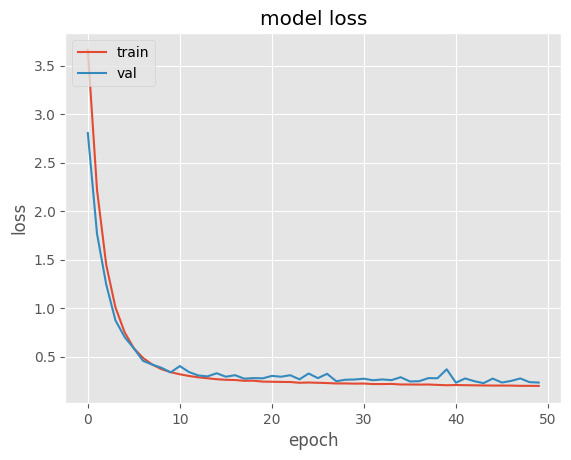

In [75]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

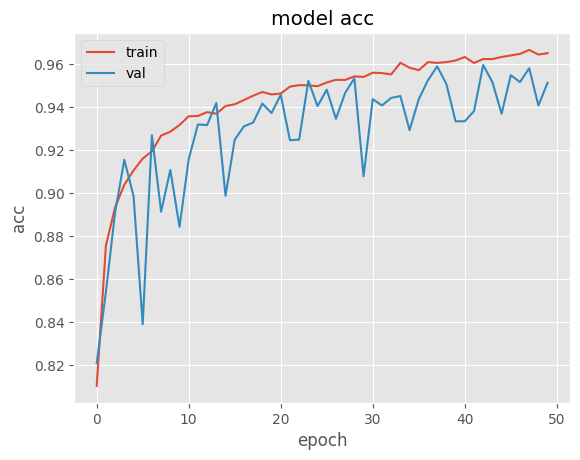

In [83]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

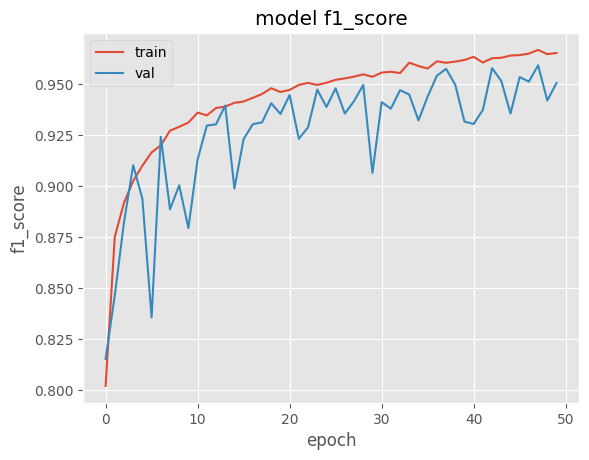

In [84]:
plt.plot(model_history.history['f1_score'])
plt.plot(model_history.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [76]:
# Save model and weights
model_name = 'van_detector_1004.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at c:\Users\JoVa994\Documents\Vandalism_Detection\Data\MIVIA_DB4_dist\training\train_new_background\saved_models\van_detector_1004.h5 


In [77]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('./saved_models/van_detector_1004.h5')
print("Loaded model from disk")
 
# Keras optimiser
opt = tf.keras.optimizers.Adam(lr=0.0001)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 95.41%


In [96]:
# from tensorflow.keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy',f1_score])
model_history=run_model_on_gpu(model, x_train,x_test, y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val), flag=1, verbose=1)

Epoch 1/50
1634/1634 [==============================] - 18s 10ms/step - loss: 3.6129 - accuracy: 0.7312 - f1_score: 0.7155 - val_loss: 2.6557 - val_accuracy: 0.7636 - val_f1_score: 0.7247
Epoch 2/50
1634/1634 [==============================] - 16s 10ms/step - loss: 2.0201 - accuracy: 0.7837 - f1_score: 0.7749 - val_loss: 1.5971 - val_accuracy: 0.8103 - val_f1_score: 0.7655
Epoch 3/50
1634/1634 [==============================] - 16s 10ms/step - loss: 1.2655 - accuracy: 0.8031 - f1_score: 0.7960 - val_loss: 1.0692 - val_accuracy: 0.8177 - val_f1_score: 0.7964
Epoch 4/50
1634/1634 [==============================] - 16s 10ms/step - loss: 0.9088 - accuracy: 0.8136 - f1_score: 0.8088 - val_loss: 0.8259 - val_accuracy: 0.8268 - val_f1_score: 0.8108
Epoch 5/50
1634/1634 [==============================] - 16s 10ms/step - loss: 0.7282 - accuracy: 0.8228 - f1_score: 0.8164 - val_loss: 0.7083 - val_accuracy: 0.8154 - val_f1_score: 0.8037
Epoch 6/50
1634/1634 [==============================] - 17s 

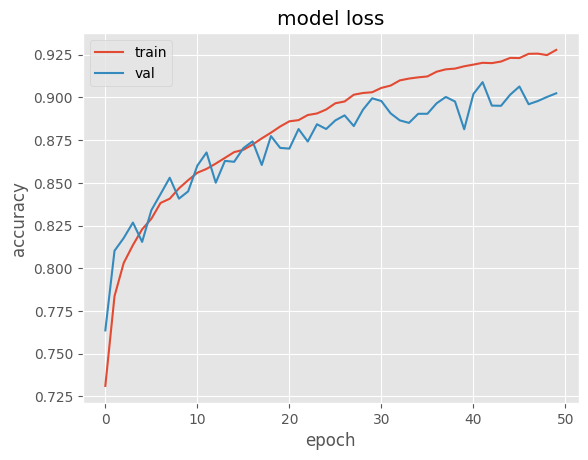

In [97]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [98]:
# Save model and weights
model_name = 'detection_model_1.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at c:\Users\JoVa994\Documents\Vandalism_Detection\Data\MIVIA_DB4_dist\training\train_new_background\saved_models\detection_model_1.h5 


In [99]:
# from tensorflow.keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy',f1_score])
model_history=run_model_on_gpu(model, x_train,x_test, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val), flag=1, verbose=1)

Epoch 1/20
1634/1634 [==============================] - 18s 10ms/step - loss: 0.3122 - accuracy: 0.9273 - f1_score: 0.9270 - val_loss: 0.3780 - val_accuracy: 0.9047 - val_f1_score: 0.9053
Epoch 2/20
1634/1634 [==============================] - 18s 11ms/step - loss: 0.3095 - accuracy: 0.9281 - f1_score: 0.9284 - val_loss: 0.3770 - val_accuracy: 0.9016 - val_f1_score: 0.9030
Epoch 3/20
1634/1634 [==============================] - 18s 11ms/step - loss: 0.3103 - accuracy: 0.9281 - f1_score: 0.9280 - val_loss: 0.3954 - val_accuracy: 0.8953 - val_f1_score: 0.8957
Epoch 4/20
1634/1634 [==============================] - 16s 10ms/step - loss: 0.3086 - accuracy: 0.9299 - f1_score: 0.9296 - val_loss: 0.3904 - val_accuracy: 0.8997 - val_f1_score: 0.8986
Epoch 5/20
1634/1634 [==============================] - 17s 10ms/step - loss: 0.3055 - accuracy: 0.9308 - f1_score: 0.9309 - val_loss: 0.3801 - val_accuracy: 0.8992 - val_f1_score: 0.8985
Epoch 6/20
1634/1634 [==============================] - 16s 

In [100]:
# Save model and weights
model_name = 'detection_model_2.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at c:\Users\JoVa994\Documents\Vandalism_Detection\Data\MIVIA_DB4_dist\training\train_new_background\saved_models\detection_model_2.h5 


In [87]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('./saved_models/van_detector_1002.h5')
print("Loaded model from disk")
 
# Keras optimiser
opt = tf.keras.optimizers.Adam(lr=0.0001)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 94.58%


In [88]:
preds = run_model_on_gpu(model, x_train,x_test, y_train, batch_size=30, epochs=2, validation_data=(x_test, y_test), flag=2, verbose=1)

preds=preds.argmax(axis=1)
preds = preds.astype(int).flatten()
preds = (label_encoder.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})
# preds = pd.concat([preds, X_test], axis=1)

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (label_encoder.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

227/227 [==============================] - 1s 5ms/step


,actualvalues,predictedvalues
170,0,0
171,3,1
172,3,1
173,1,2
174,3,3
175,3,3
176,3,3
177,2,2
178,3,1
179,3,3


In [89]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

def evaluate_model(y_true, y_pred):
    """
    Evaluate the performance of a classification model.

    Parameters:
    y_true (list or np.array): True labels of the test dataset.
    y_pred (list or np.array): Predicted labels from the model.

    Returns:
    dict: A dictionary containing various performance metrics.
    """
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')  # Use 'macro' or 'micro' as needed
    recall = recall_score(y_true, y_pred, average='weighted')        # Use 'macro' or 'micro' as needed
    f1 = f1_score(y_true, y_pred, average='weighted')                # Use 'macro' or 'micro' as needed
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(conf_matrix)

    # Create a dictionary to hold the metrics
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,

    }

    return metrics


def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [90]:
performance_metrics = evaluate_model(finaldf['actualvalues'], finaldf['predictedvalues'])
for metric, value in performance_metrics.items():
    print(f"{metric}: {value}")

[[1567   19   17    0]
 [  22 1550   16    4]
 [  54  183 1545    9]
 [   1   36    7 1763]]
Accuracy: 0.9458265861916679
Precision: 0.9491512070036147
Recall: 0.9458265861916679
F1 Score: 0.9458059000437173


In [167]:
(label_encoder.classes_) #['Gunshot_or_gunfire' 'Screams' 'Shatter']

array([0, 1, 2, 3])

0.9458265861916679


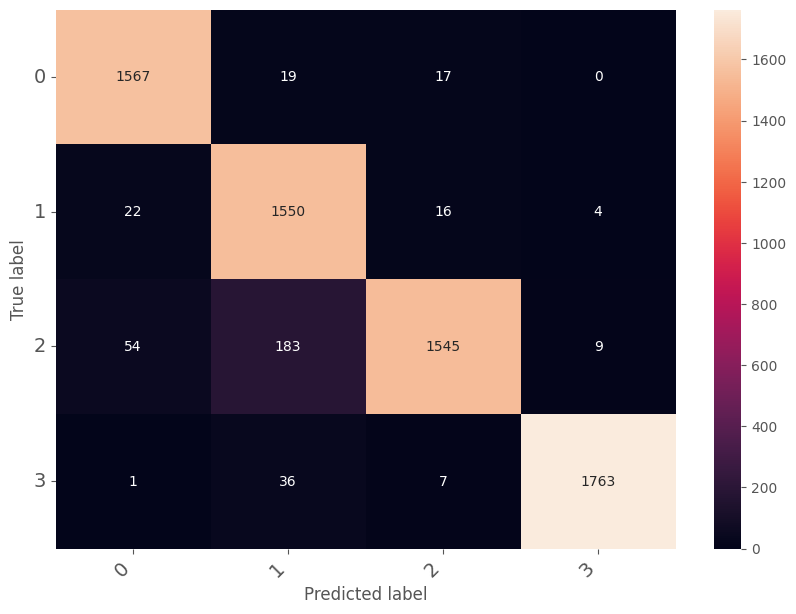

In [91]:
 #Get the predictions file 
# finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)